In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameters
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size)*sigma


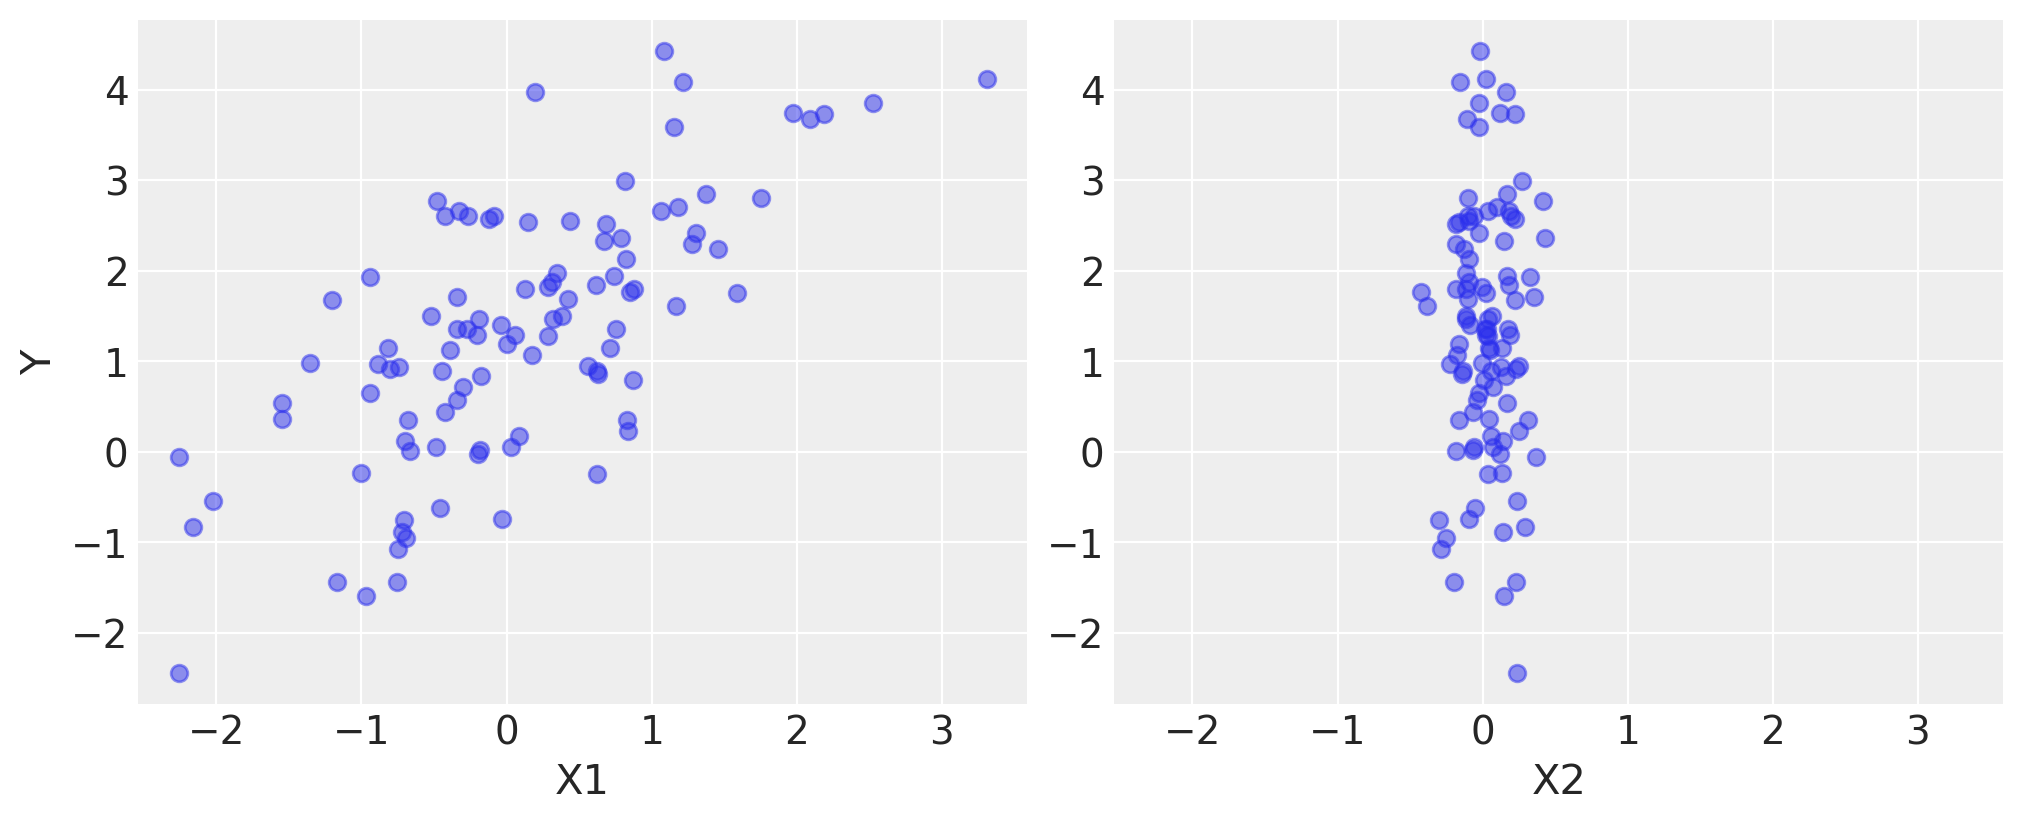

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y, alpha=0.5)
axes[1].scatter(X2, Y, alpha=0.5)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

## Model specification

In [5]:
import pymc as pm

print(f"Running PyMC v{pm.__version__}...")




Running PyMC v5.22.0...


In [6]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [7]:
with basic_model:
    # Draw 1000 samples from the posterior
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


/Users/sorenjorgensen/miniconda3/envs/pymc_py311/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
idata.posterior['alpha'].sel(draw=slice(0,4))

<xarray.DataArray 'alpha' (chain: 2, draw: 5)> Size: 80B
array([[1.23770354, 1.25009307, 1.09493456, 1.1974182 , 1.16915251],
       [1.0906373 , 1.28386945, 1.16046117, 1.19496183, 1.16374642]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 40B 0 1 2 3 4

In [10]:
# Or use the slice sampling algorithm to sample the parameters in stead of NUTS

with basic_model:
    # instantiate the slice sampler
    step = pm.Slice()

    # Draw 5000 samples from the posterior
    idata_slice = pm.sample(5000, step=step)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


/Users/sorenjorgensen/miniconda3/envs/pymc_py311/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Posterior analysis

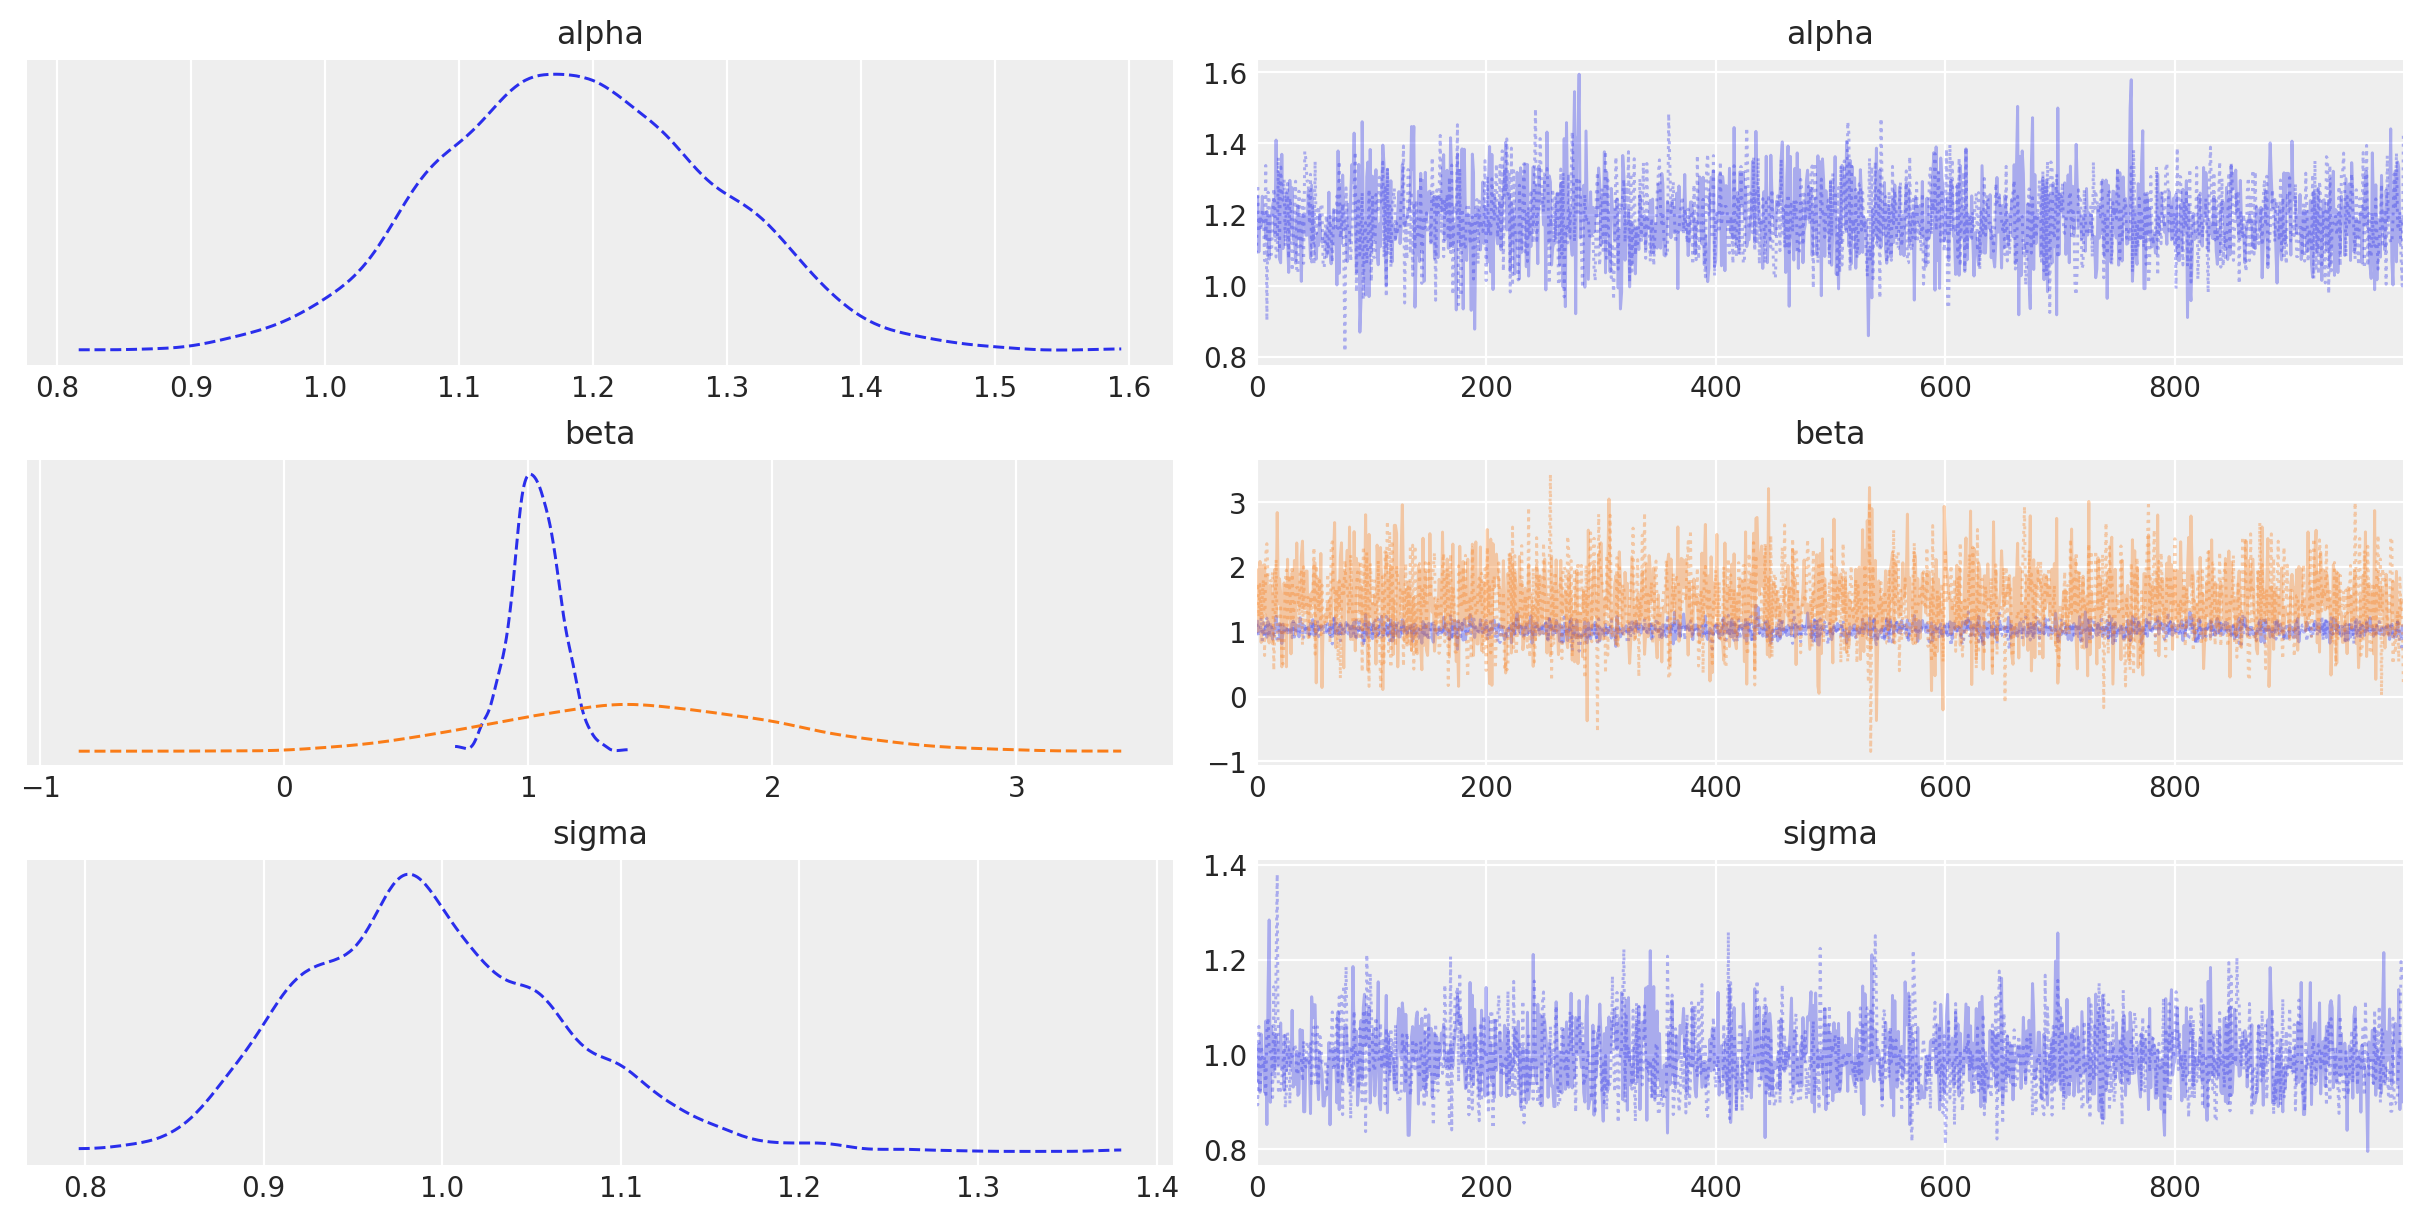

In [11]:
# PyMC comes with 'arviz' built-in, so we can use it to plot the results

az.plot_trace(idata, combined=True);

In [12]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.19,0.10,0.99,1.37,0.00,0.00,2820.44,1657.02,1.0
beta[0],1.03,0.10,0.85,1.21,0.00,0.00,2593.69,1551.33,1.0
beta[1],1.45,0.57,0.40,2.50,0.01,0.01,3034.97,1780.53,1.0
sigma,0.99,0.07,0.87,1.13,0.00,0.00,2126.81,1325.88,1.0


# Case study 1: Educational Outcomes for Hearing-impaired Children

## The Data


In [15]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


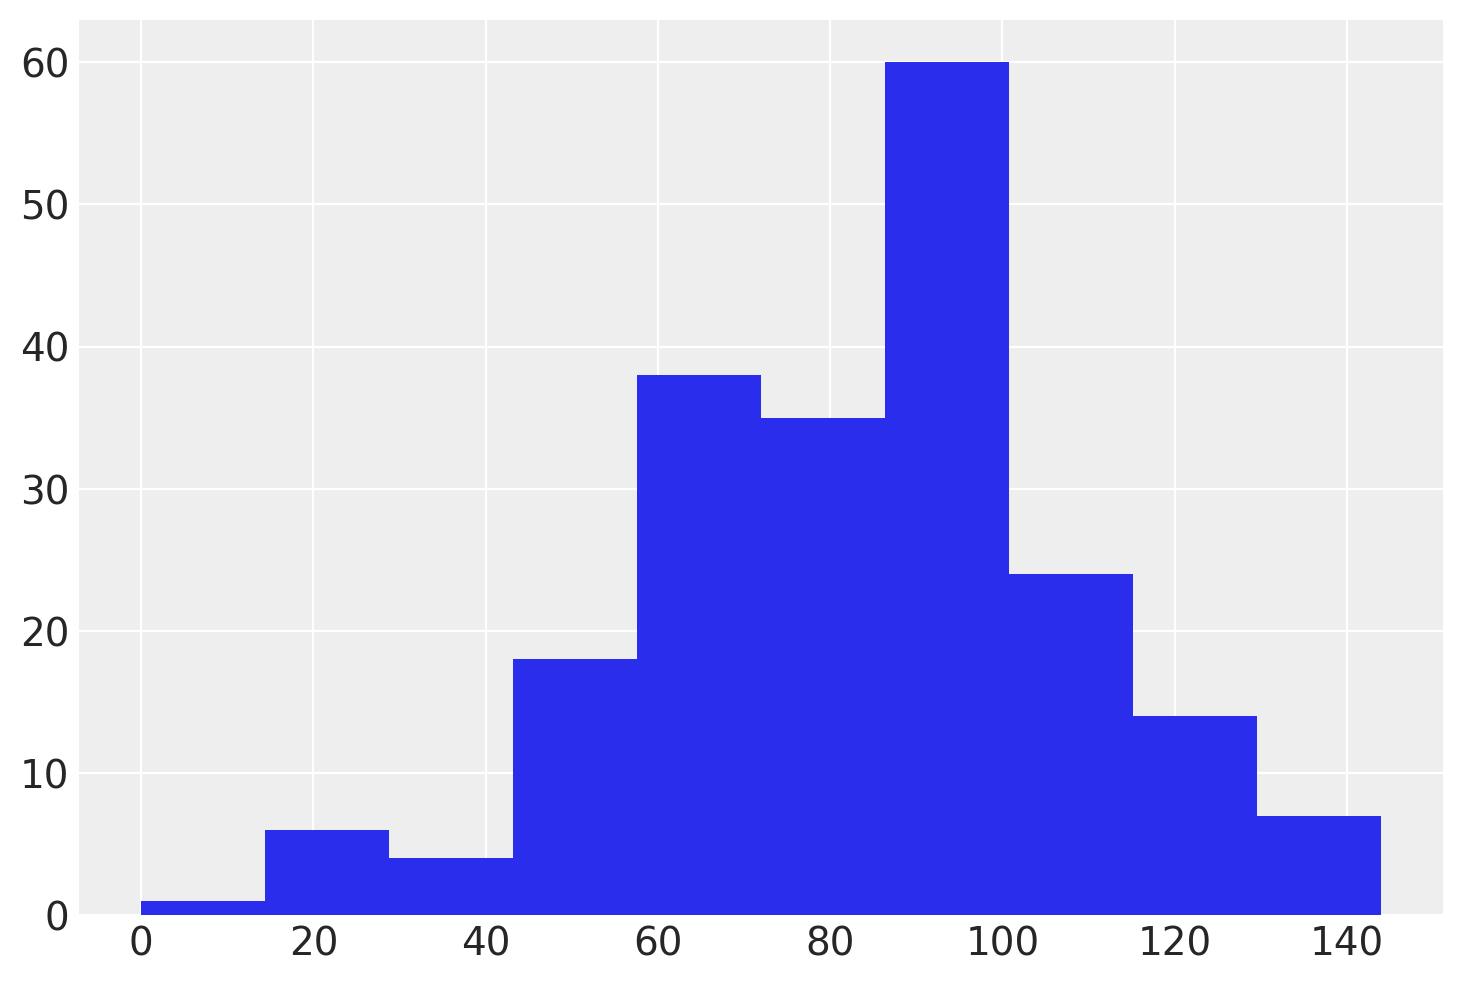

In [16]:
test_scores['score'].hist();

In [17]:
# Drop NA values for simplicity
X = test_scores.dropna().astype(float)
y = X.pop('score')

# Standardize the predictors
X -= X.mean()
X /= X.std()

N, D = X.shape

## The model

Multivariate regression with regularization.

Select a (shrinkage) prior that has long tails.

The horseshoe prior is used here; 

$\beta_j \sim N(0, \tau^2 \tilde{\lambda_i^2})$

We use $\tau \sim \text{Half-StudentT}_2 (\frac{D_0}{D-D_0} \cdot \frac{\sigma}{\sqrt{N}})$

We take a guess at $D_0$ as half the original parameters. 


In [18]:
D0 = int(D / 2)

In [20]:
import pytensor.tensor as pt

with pm.Model(coords={'predictors': X.columns.values}) as test_score_model:
    # Prior error on SD
    sigma = pm.HalfNormal("sigma", sigma=25)

    # Global shrinkage prior
    tau = pm.HalfStudentT('tau', 2, D0/(D-D0) * sigma/np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT('lam', 5, dims="predictors")
    c2 = pm.InverseGamma('c2', 1, 1)
    z = pm.Normal('z', 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic('beta', z*tau*lam*pt.sqrt(c2/(c2 + tau**2 * lam**2)), dims="predictors")
    # No intercept
    beta0 = pm.Normal('beta0', 100, 25.0)

    scores = pm.Normal('scores', beta0 + pt.dot(X.values, beta), sigma=sigma, observed=y.values)

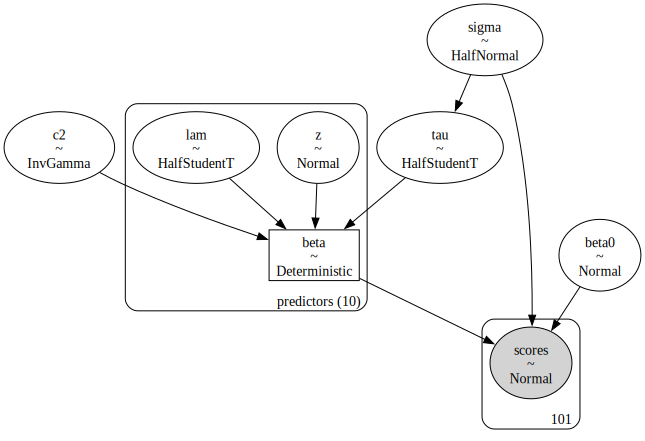

In [21]:
pm.model_to_graphviz(test_score_model)

In [22]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


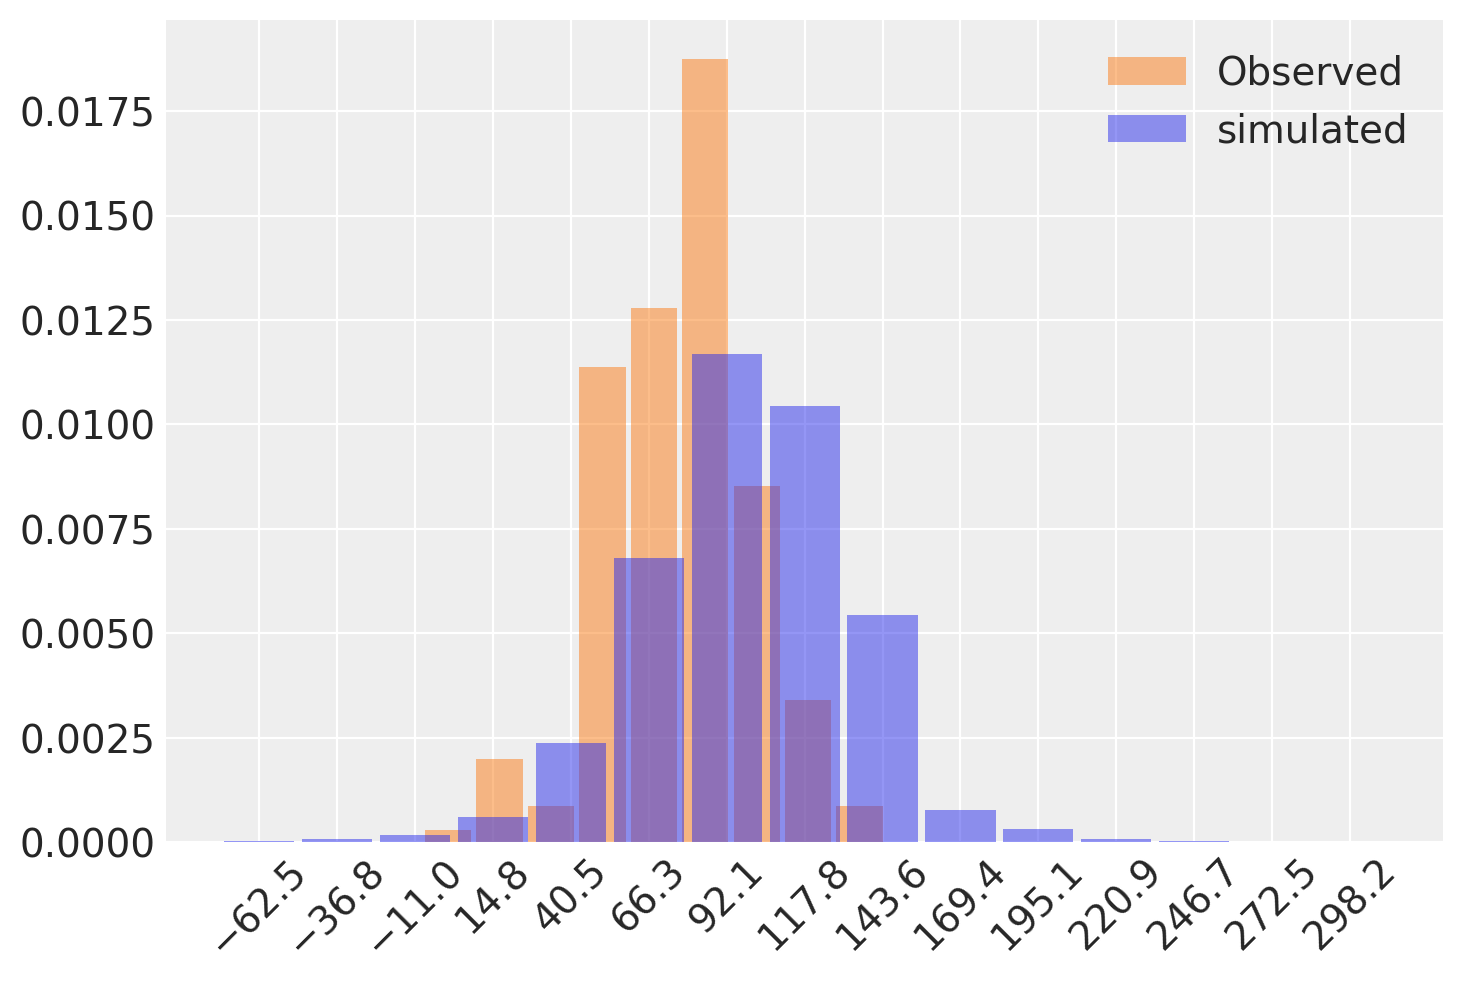

In [26]:
az.plot_dist(
    test_scores['score'].values,
    kind='hist',
    color='C1',
    hist_kwargs={'alpha': 0.5},
    label='Observed',
)

az.plot_dist(
    prior_samples.prior_predictive['scores'],
    kind='hist',
    hist_kwargs={'alpha': 0.5},
    label='simulated',
)
plt.xticks(rotation=45);

In [27]:
# Give the sampler more time to tune

with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 48 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [28]:
# Give the sampler more time to tune

with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 66 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


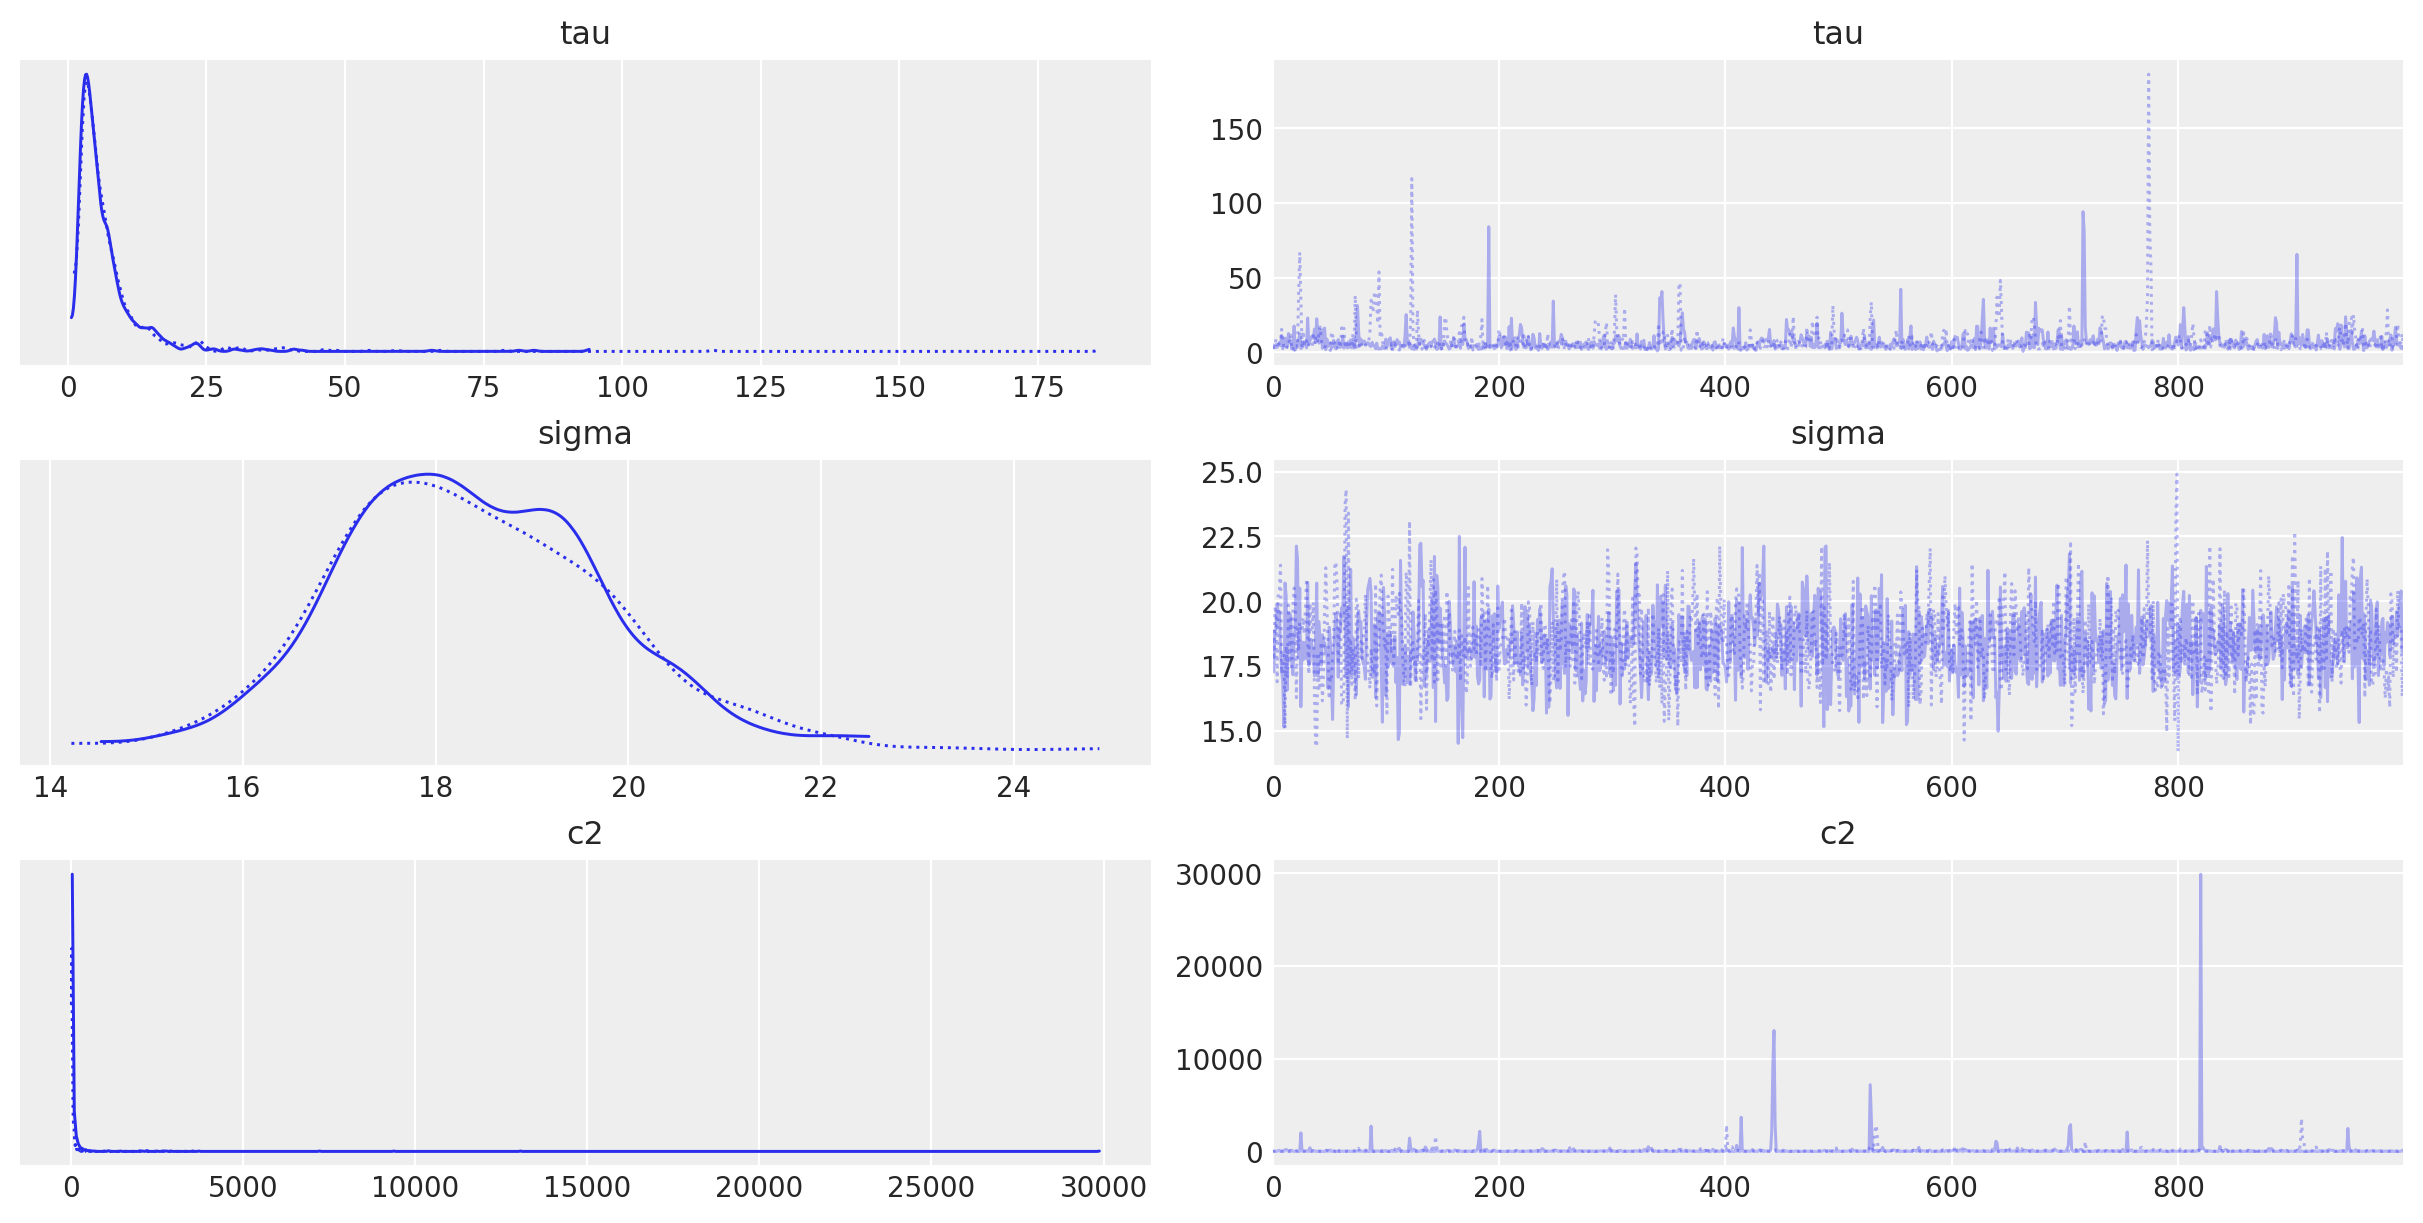

In [30]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]);

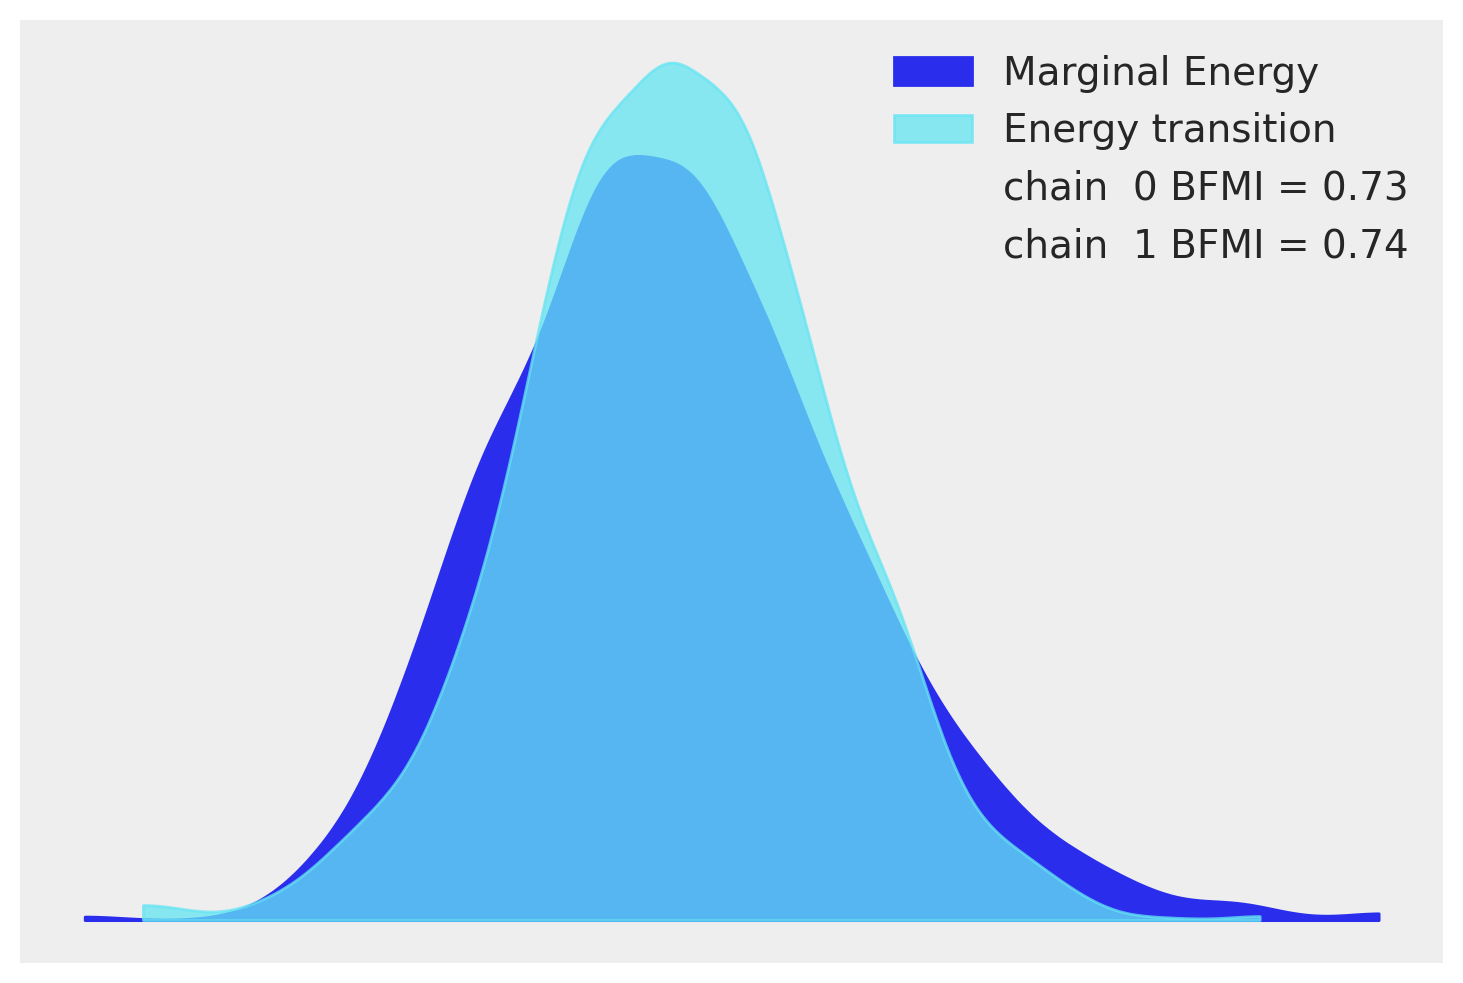

In [31]:
az.plot_energy(idata);

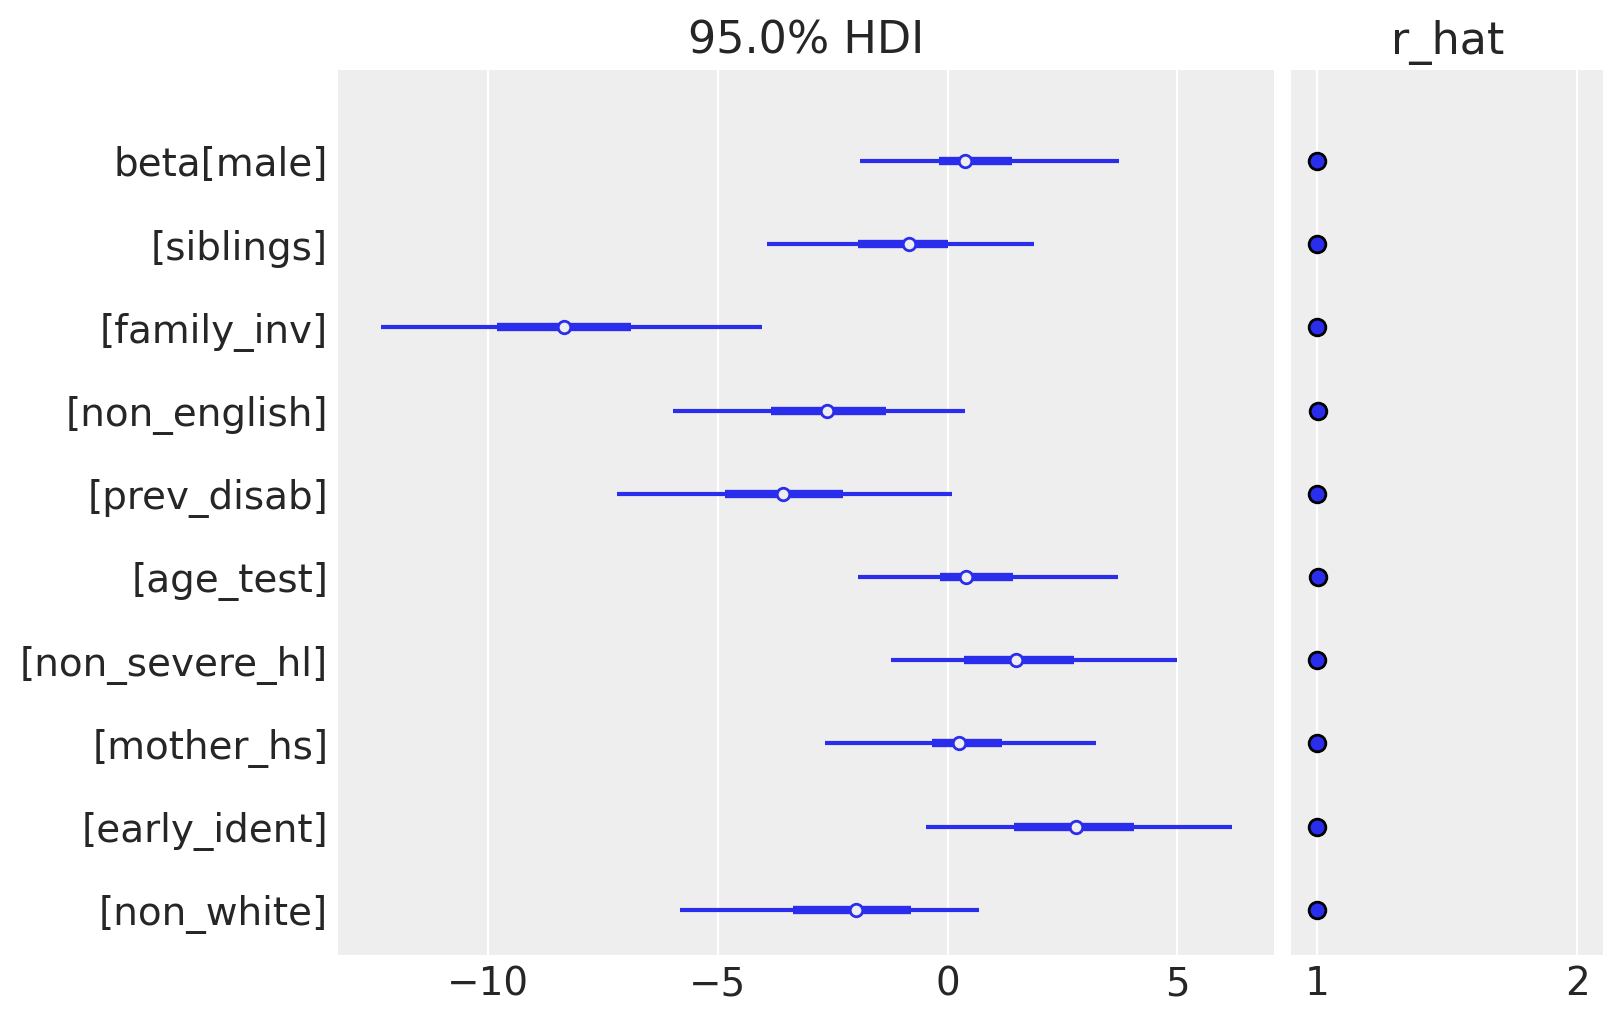

In [32]:
az.plot_forest(idata, var_names=['beta'], combined=True, hdi_prob=0.95, r_hat=True);

# Case study 2: Coal mining disasters

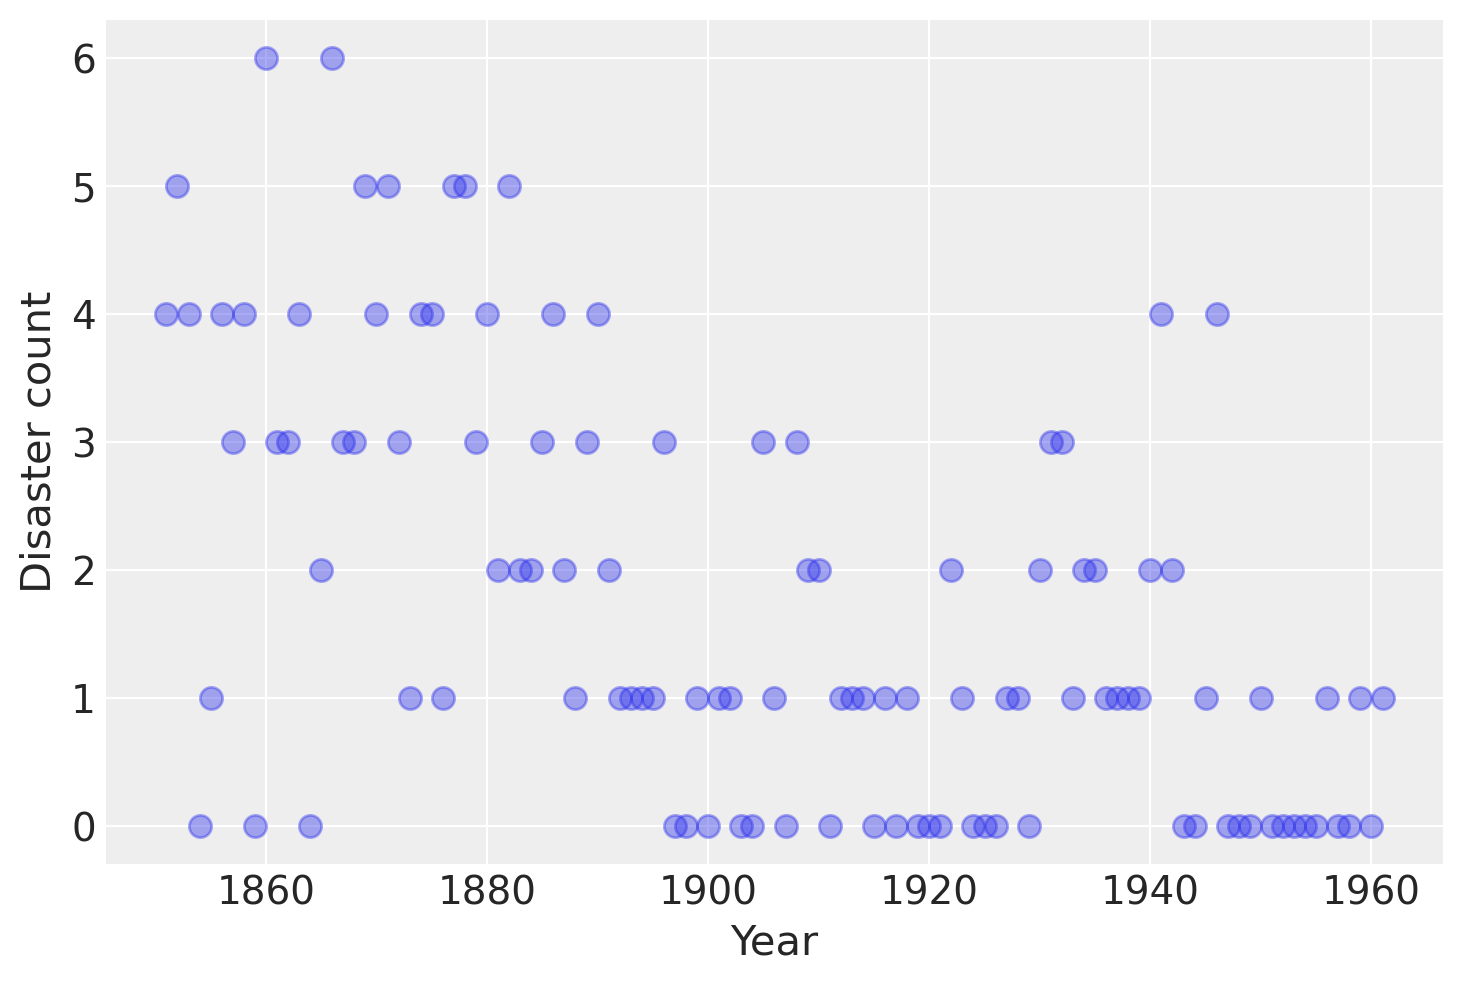

In [16]:
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, 4, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, 2, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [17]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

In [18]:
with disaster_model:
    idata = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


/Users/sorenjorgensen/miniconda3/envs/pymc_py311/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 42 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


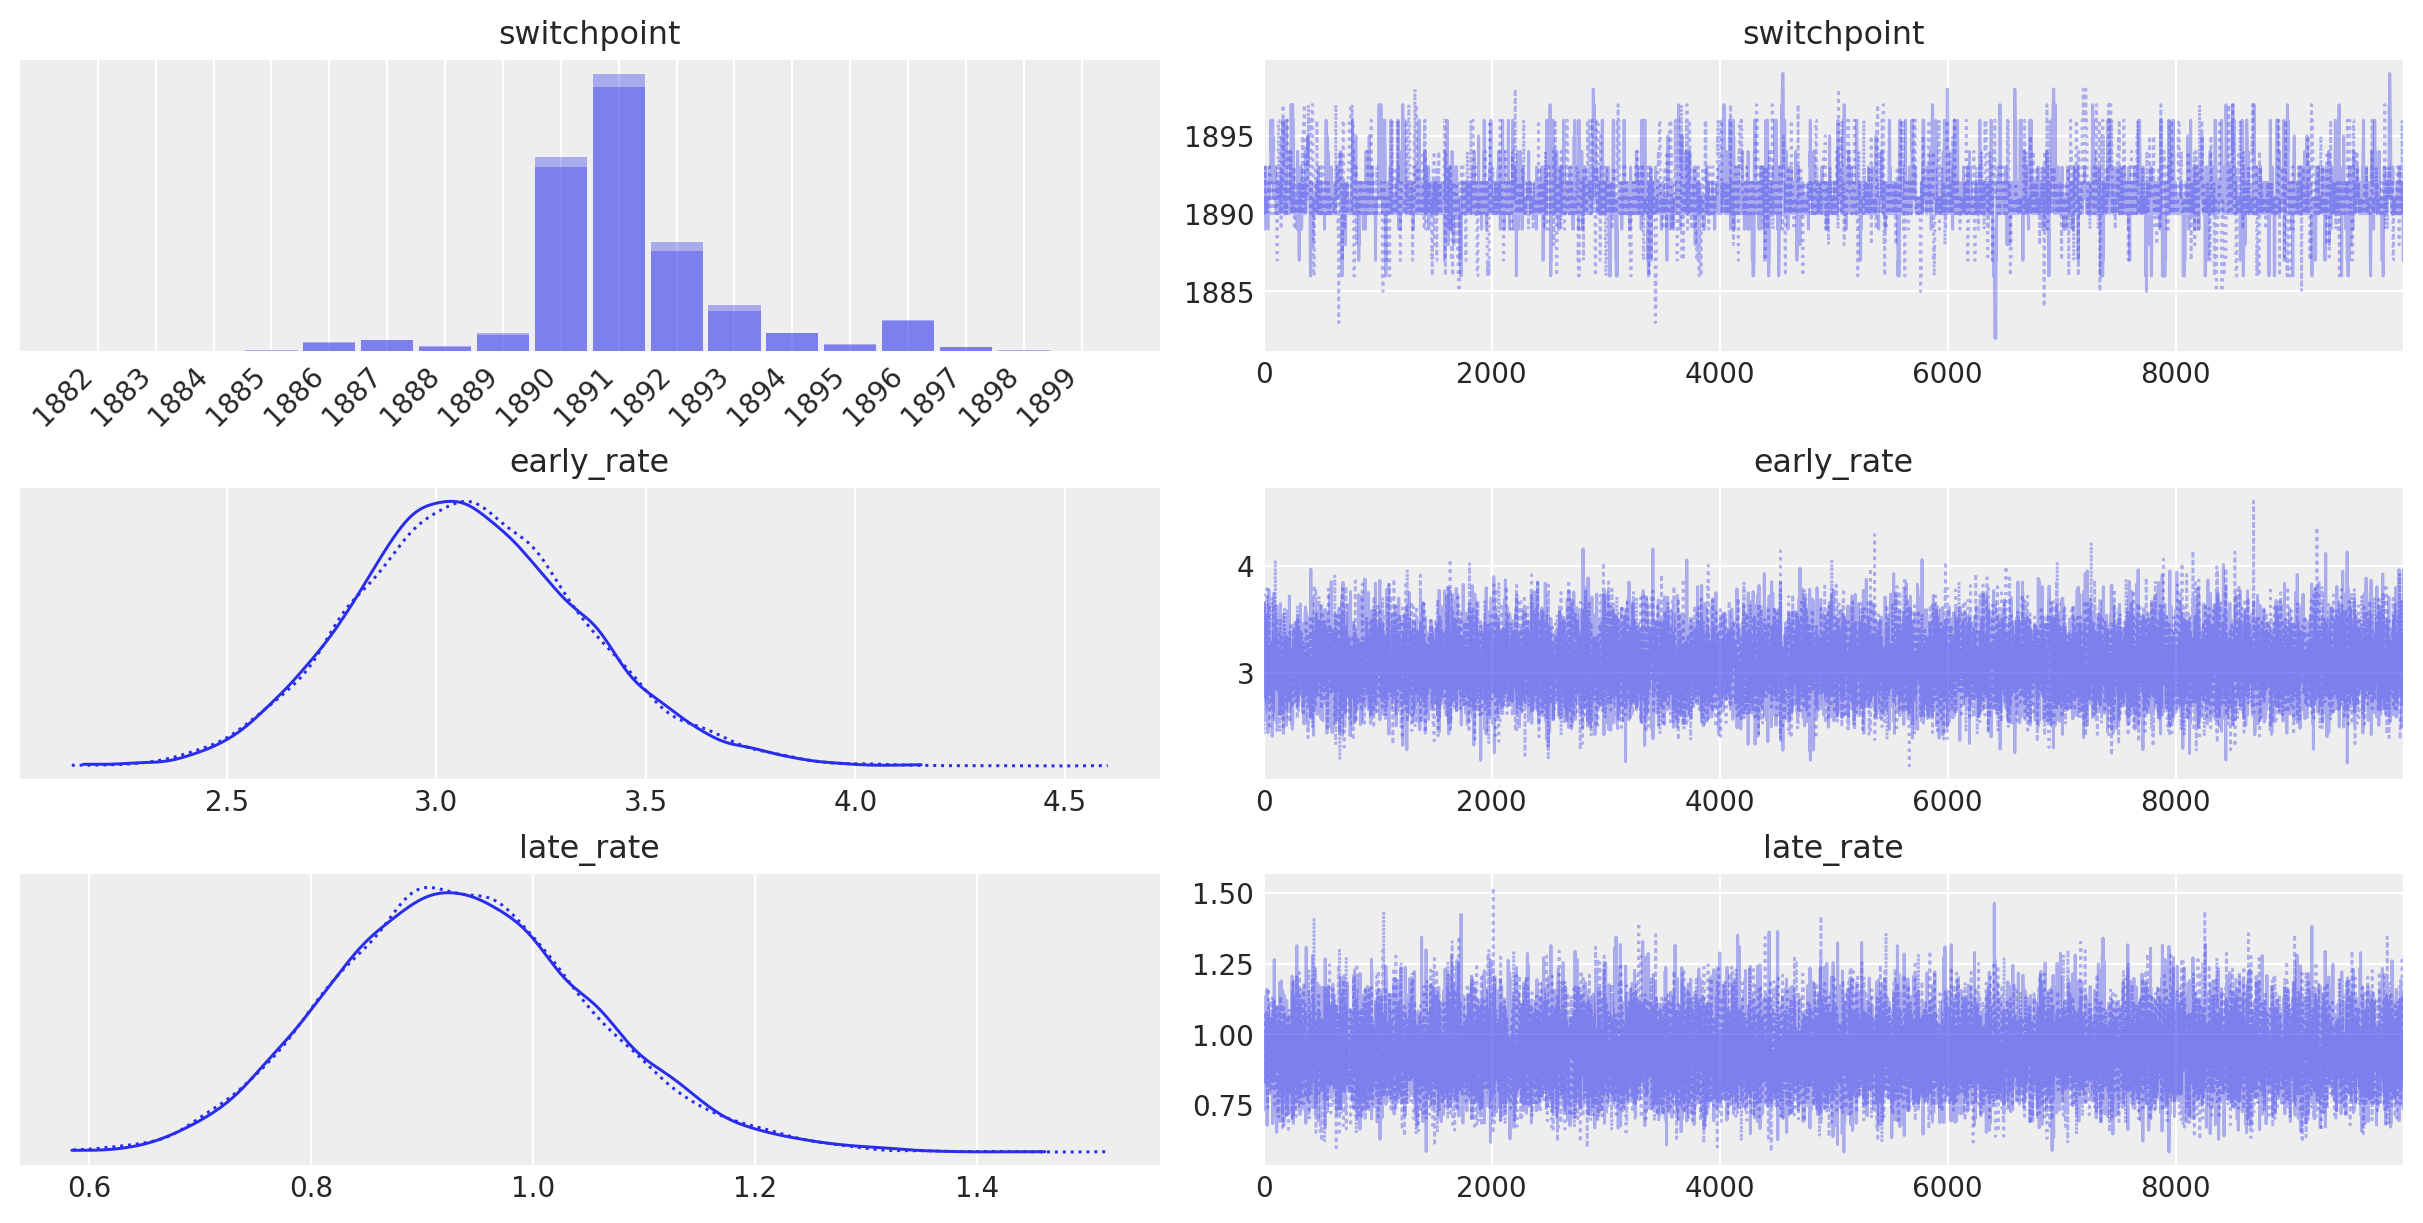

In [19]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

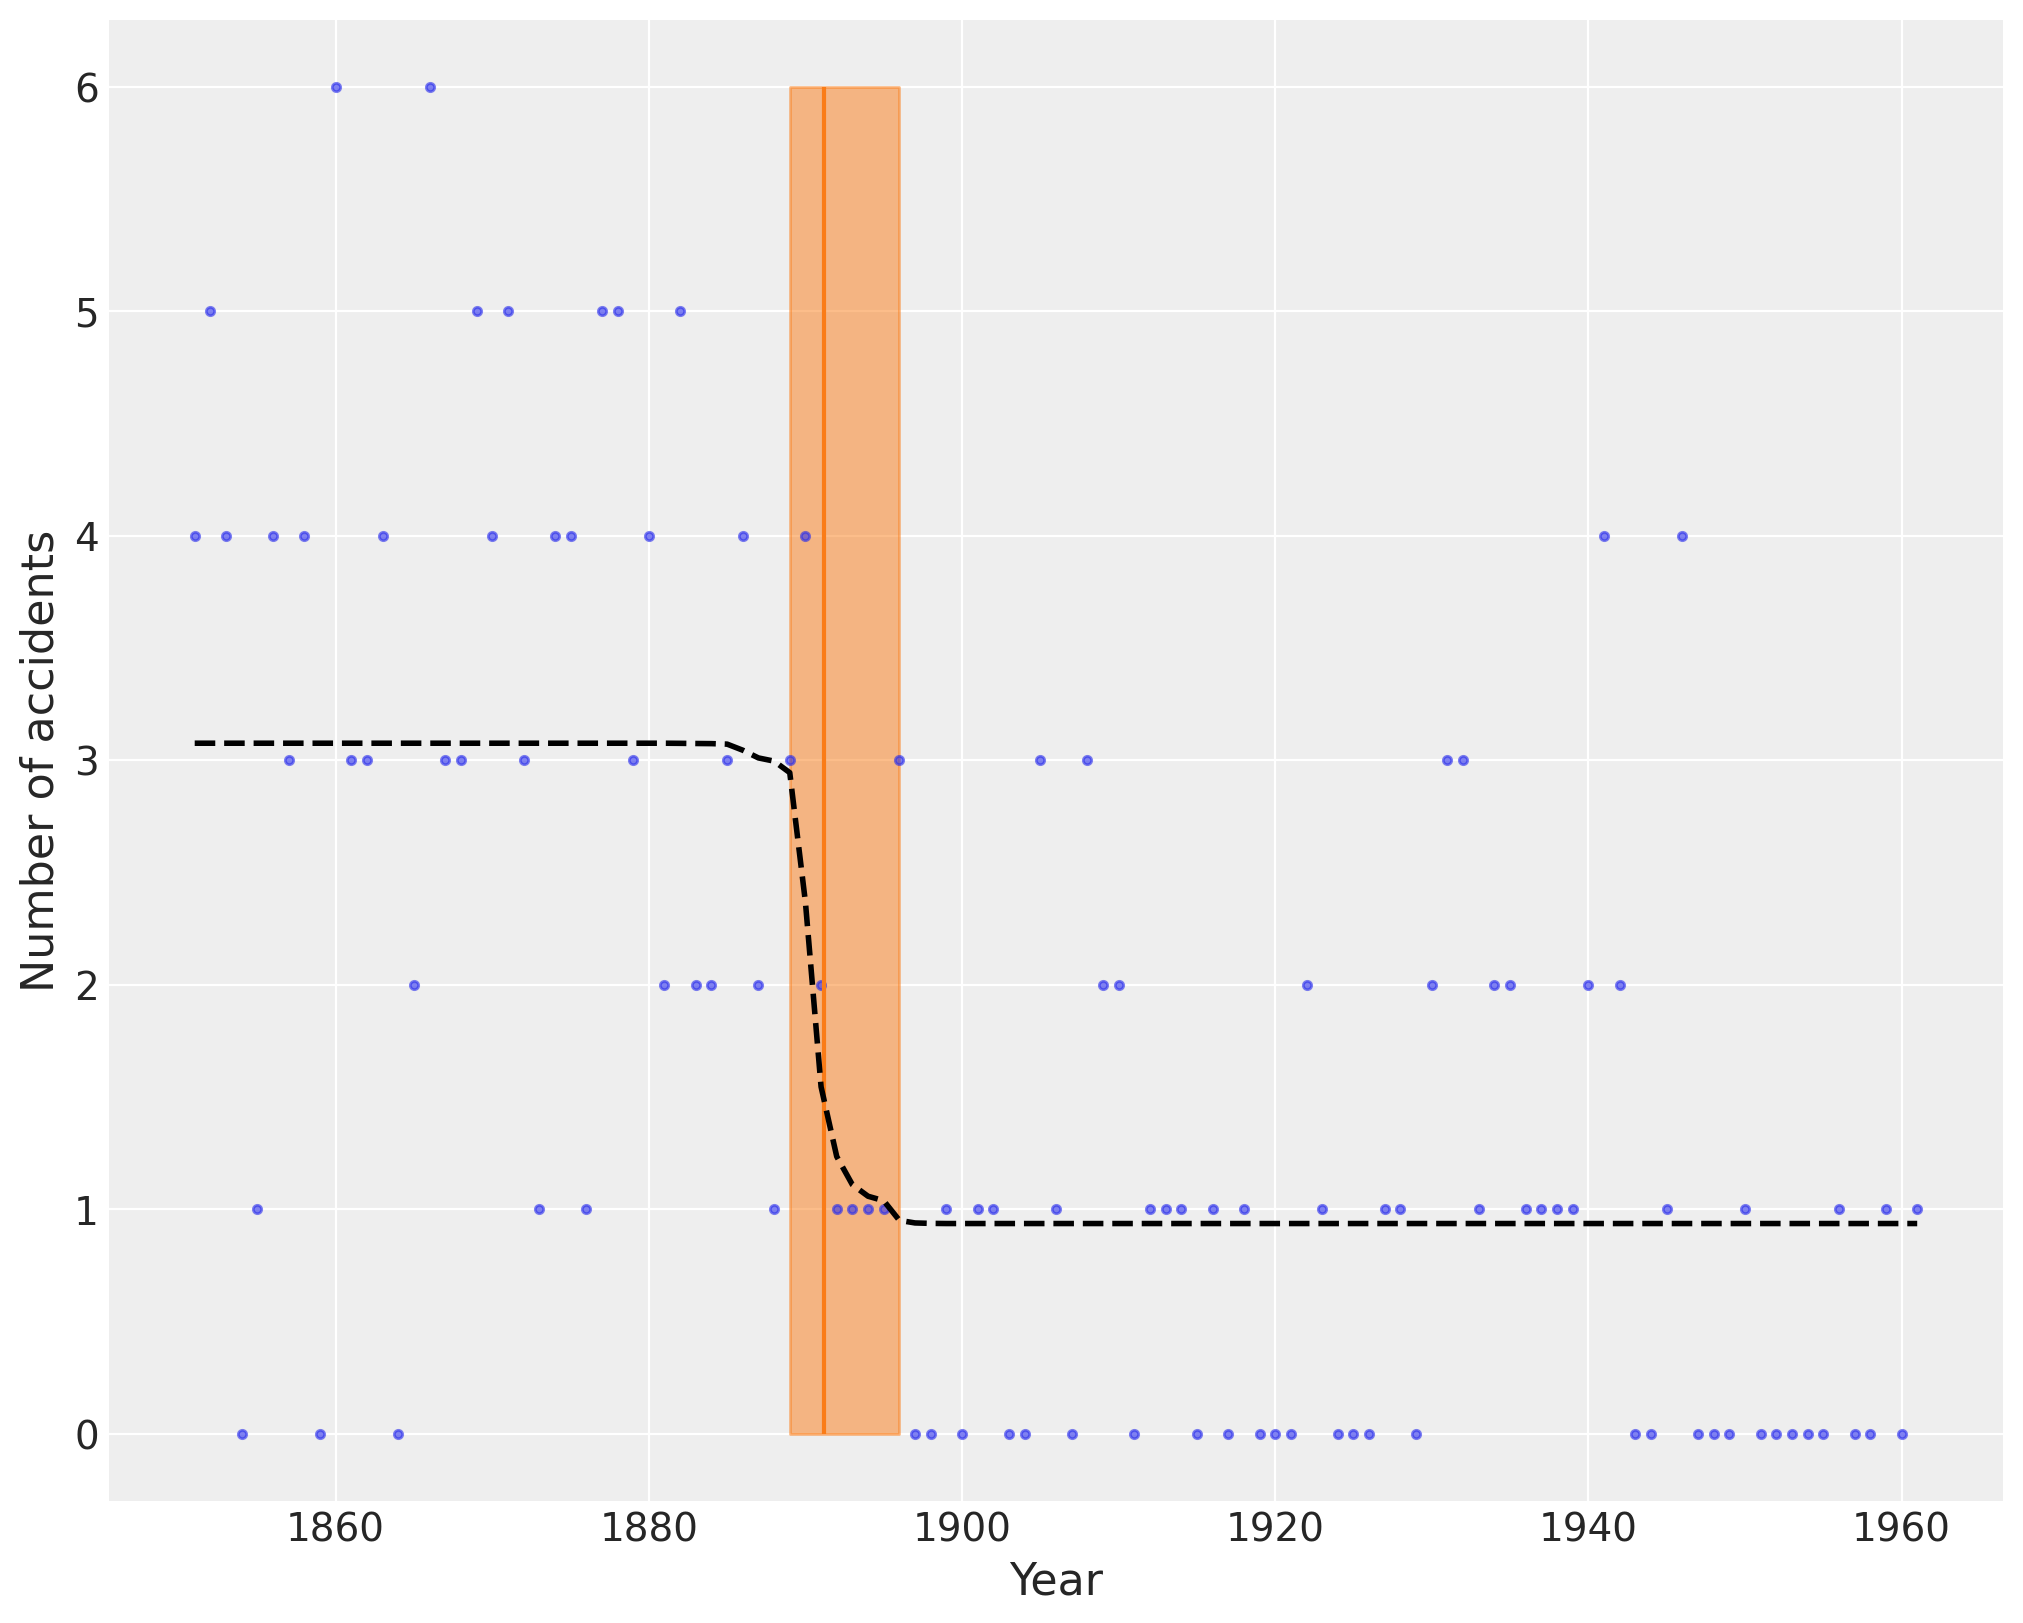

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);


# Ending notes

I was not able to get the automatic imputation working, so I removed the `np.nan` values. 

This means I have to do manual imputation on my real data (or remove `nan`s)